# tsGT example (JAX/Flax version)
This is an example notebook for tsGT, migrated from Trax to JAX/Flax.


In [28]:
import sys
sys.path.append('code')

# Core imports
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# JAX/Flax imports (replacing Trax)
import jax
import optax  # Replaces trax.optimizers

# Project imports
import inputs
import models
import trainer
import datasets
from serial_predictor import SerialPredictor
from distribution_predictor import DistributionPredictor
from iqn_predictor import IQNPredictor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Example time series data

In [39]:
from itertools import cycle
import random


start_date = pd.Timestamp('2018-01-01 18:30:00')
periods = 200
train_window = 40 # size of training windows when splitting
eval_window = 10 # forecast horizon
series_length = 20 # length of samples from the training window
# so series_length = context + eval_window
freq = '1h' 


def prepare_example_data(periods, start_date, freq) -> pd.DataFrame:
    t = np.linspace(0, 5 * np.pi, periods)
    frequencies = [0.5, 1, 1.5, 2]
    sine_waves = [np.sin(f * t) for f in frequencies]
    df = pd.DataFrame(sine_waves).T
    df.index = pd.date_range(start_date, periods=periods, freq=freq)
    df.index.name = 'date'
    return df


df = prepare_example_data(periods=periods, start_date=start_date, freq=freq)


def get_list(df, train_window, eval_window, steps, freq):
  start_date = df.index.min()
  end_date = df.index.max() - pd.Timedelta(freq) * (train_window + eval_window)
  delta = ((end_date - start_date) / (steps - 1)).floor(freq)
  return [start_date + i * delta for i in range(steps)]

window_starts = get_list(df, train_window, eval_window, steps=3, freq=freq)

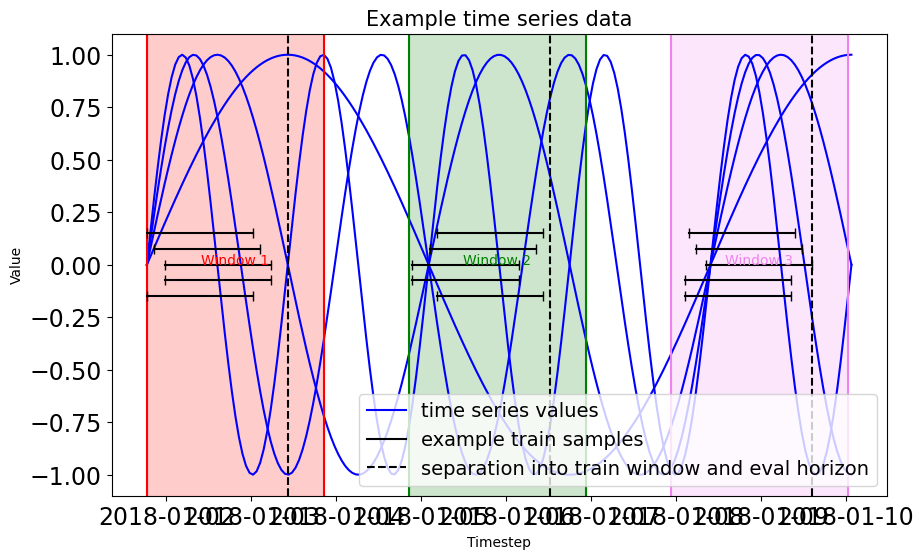

In [40]:
#################
# Visualization #
#################

plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], color='blue')

unit = pd.Timedelta(freq)
for i, (start, color) in enumerate(zip(window_starts, cycle(["red", "green", "violet"]))):
    plt.axvline(start, color=color, linestyle='-')
    plt.axvline(start + unit * (train_window), color='black', linestyle='--')
    plt.axvline(start + unit * (train_window + eval_window), color=color, linestyle='-')
    plt.axvspan(start, start + unit * (train_window + eval_window), color=color, alpha=0.2)
    plt.text(start + unit * (train_window + eval_window) / 2, 0, f'Window {i + 1}', color=color, ha='center')

    # plot example train samples
    for j in np.linspace(-0.15, 0.15, 5):
        r = random.randint(0, train_window - series_length - eval_window)
        r = unit * r + start      
        plt.plot([r, r + unit * (series_length + eval_window)], [j, j], color='black')
        plt.plot(r, j, marker='|', color='black', markersize=7)
        plt.plot(r + unit * (series_length + eval_window), j, marker='|', color='black', markersize=7)

plt.title('Example time series data', size=15)
plt.xlabel('Timestep', size=10)
plt.ylabel('Value', size=10)

plt.plot([], [], color='blue', label="time series values")
plt.plot([], [], color='black', label="example train samples")
plt.plot([], [], color='black', linestyle='--', label="separation into train window and eval horizon")

plt.legend(loc='lower right')
plt.show()

# Dataset and loader

In [31]:
dataset_list = [
    datasets.Dataset(
        data_full=datasets.DataCollection(data_loader=lambda: df),
        start_date=pd.Timestamp(start_date),
        train_window=train_window,
        eval_window=eval_window,
        series_length=series_length,
    ) for start_date in window_starts]

inputs_iterables = [
    functools.partial(
        inputs.CreateInputs,
        dataset=dataset,
        batch_size=4,
        series_length=series_length,
        weighted_sampling=True,
    ) for dataset in dataset_list]

# Model and predictor

In [32]:
def model_body_fn(precision=2):
    """Create transformer body model."""
    return models.TransformerBody(
        d_model=64,
        d_ff_mul=2,          # (optional but commonly used in this repo)
        n_layers=2,
        n_heads=2,
        max_len=100,
        dropout_rate=0.1,    # <-- correct name
        conv_kernel=3,       # (optional)
    )
# Predictor class (using functools.partial for configuration)
# Choose one of: SerialPredictor, DistributionPredictor, IQNPredictor
predictor_class = functools.partial(
    SerialPredictor,
    d_in=256,
    vocab_size=64,
    precision=3,
    significance_decay=0.7,
    low=-2.0,  # Adjusted for sine wave range
    high=2.0,
    normalization="per_ts",
    accelerate_predict_model=False,  # Disable JIT for easier debugging
)

# Training: Train tsGT for a few iterations

In [35]:
# Training with JAX/Flax/Optax
# Uses train_predictor which supports the full predictor workflow

states, histories, predictors_list = [], [], []

for i, inputs_iterable in enumerate(inputs_iterables):
    print(f"\n{'='*50}")
    print(f"Training window {i+1}/{len(inputs_iterables)}")
    print(f"{'='*50}")
    
    state, history, predictor = trainer.train_predictor(
        output_dir=f'./out/window_{i}',
        inputs=functools.partial(inputs_iterable, full_eval=False),
        model_body_fn=model_body_fn,
        predictor_class=predictor_class,
        optimizer=optax.adam,
        learning_rate=0.001,
        n_steps=1000,  # Small number for quick demo
        eval_every=5,
        n_eval_batches=1,
        calc_eval_loss=True,
    )
    states.append(state)
    histories.append(history)
    predictors_list.append(predictor)

print("\nTraining complete!")


Training window 1/3
Training on 1 device(s)
Batch shapes: series=(4, 20), inputs=(4, 20, 4), target=(4, 20), mask=(4, 20)
Model has 136,832 parameters
Starting training for 1000 steps...
Step 1/1000 | Loss: 4.2910 | Time: 5.3s
Step 50/1000 | Loss: 3.0219 | Time: 6.0s
Step 100/1000 | Loss: 2.8285 | Time: 6.6s
Step 150/1000 | Loss: 2.2851 | Time: 7.2s
Step 200/1000 | Loss: 2.5014 | Time: 7.7s
Step 250/1000 | Loss: 2.0127 | Time: 8.3s
Step 300/1000 | Loss: 1.9328 | Time: 8.9s
Step 350/1000 | Loss: 2.0315 | Time: 9.5s
Step 400/1000 | Loss: 1.6918 | Time: 10.0s
Step 450/1000 | Loss: 1.6158 | Time: 10.6s
Step 500/1000 | Loss: 1.4057 | Time: 11.2s
Step 550/1000 | Loss: 1.3363 | Time: 11.8s
Step 600/1000 | Loss: 1.4406 | Time: 12.3s
Step 650/1000 | Loss: 1.5203 | Time: 12.9s
Step 700/1000 | Loss: 1.4808 | Time: 13.5s
Step 750/1000 | Loss: 1.4955 | Time: 14.1s
Step 800/1000 | Loss: 1.1729 | Time: 14.6s
Step 850/1000 | Loss: 1.0192 | Time: 15.2s
Step 900/1000 | Loss: 1.0069 | Time: 15.8s
Step 9

# Simulation

Generate simulation data and show a dataframe

In [36]:
import simulations


dfs_sim = [
    simulations.simulate(
        inputs_fn=functools.partial(inputs_iterable, full_eval=True),
        weights=state.params,  
        predictor=predictor,
        dataset=dataset,
        n_samples=8)  
    for inputs_iterable, predictor, state, dataset in zip(
        inputs_iterables, predictors_list, states, dataset_list
    )
]

print(f"Generated {len(dfs_sim)} simulation dataframes")
dfs_sim[0].head()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.47s/it]

Generated 3 simulation dataframes


,index,ts_id,pred_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,gt_13,gt_14,gt_15,gt_16,gt_17,gt_18,gt_19,eval_start,eval_end,horizon
0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.867338,0.847024,0.825391,0.802472,0.778304,0.752923,0.72637,2018-01-03 10:30:00,2018-01-04 05:30:00,20
1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.867338,0.847024,0.825391,0.802472,0.778304,0.752923,0.72637,2018-01-03 10:30:00,2018-01-04 05:30:00,20
2,2,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.867338,0.847024,0.825391,0.802472,0.778304,0.752923,0.72637,2018-01-03 10:30:00,2018-01-04 05:30:00,20
3,3,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.867338,0.847024,0.825391,0.802472,0.778304,0.752923,0.72637,2018-01-03 10:30:00,2018-01-04 05:30:00,20
4,4,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.867338,0.847024,0.825391,0.802472,0.778304,0.752923,0.72637,2018-01-03 10:30:00,2018-01-04 05:30:00,20


In [38]:
dfs_sim[1].head()

,index,ts_id,pred_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,gt_13,gt_14,gt_15,gt_16,gt_17,gt_18,gt_19,eval_start,eval_end,horizon
0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.99474,-0.989923,-0.983565,-0.975675,-0.966265,-0.955351,-0.942948,2018-01-06 07:30:00,2018-01-07 02:30:00,20
1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.99474,-0.989923,-0.983565,-0.975675,-0.966265,-0.955351,-0.942948,2018-01-06 07:30:00,2018-01-07 02:30:00,20
2,2,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.99474,-0.989923,-0.983565,-0.975675,-0.966265,-0.955351,-0.942948,2018-01-06 07:30:00,2018-01-07 02:30:00,20
3,3,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.99474,-0.989923,-0.983565,-0.975675,-0.966265,-0.955351,-0.942948,2018-01-06 07:30:00,2018-01-07 02:30:00,20
4,4,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.99474,-0.989923,-0.983565,-0.975675,-0.966265,-0.955351,-0.942948,2018-01-06 07:30:00,2018-01-07 02:30:00,20


# Evaluate and visualize

Finished processing 3 experiments in 0.00 sec.
Computing metrics and predictions...
Finished computing metrics in 0.00 sec.
Plotting p-value strips...
Computing statistics for p_values...
Saving the resulting dict...
Finished saving in 0.30 sec.
Plotting trajectories with violin plots...


  0%|                                                                                             | 0/3 [00:00<?, ?it/s]/home/xris/miniconda3/envs/ts_flax/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
  0%|                                                                                             | 0/3 [00:00<?, ?it/s]


IndexError: list index out of range
  In call to configurable 'evaluate' (<function evaluate at 0x7fa26b56a830>)

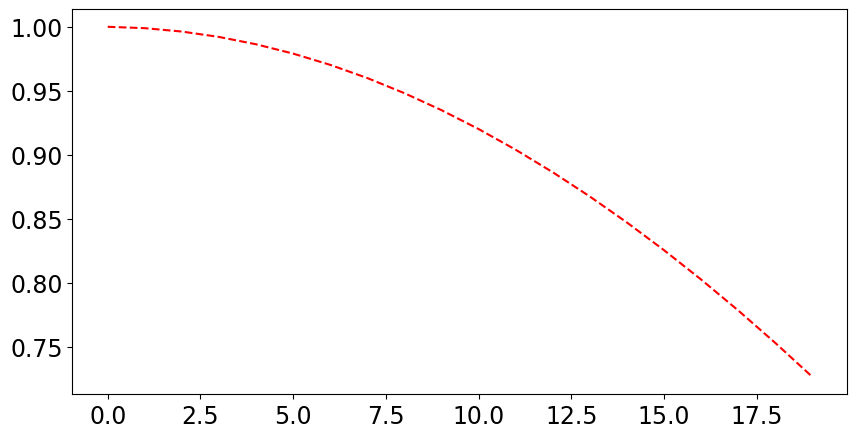

In [37]:
import evaluation


train_data = [dataset.train_data for dataset in dataset_list]

evaluation.evaluate(
    train_data=train_data,
    sim_dataframes=dfs_sim,
    output_dir="./out",
    normalize=None,
    average_preds=False,
)

Results are stored now in `./out/results/results.pkl`.

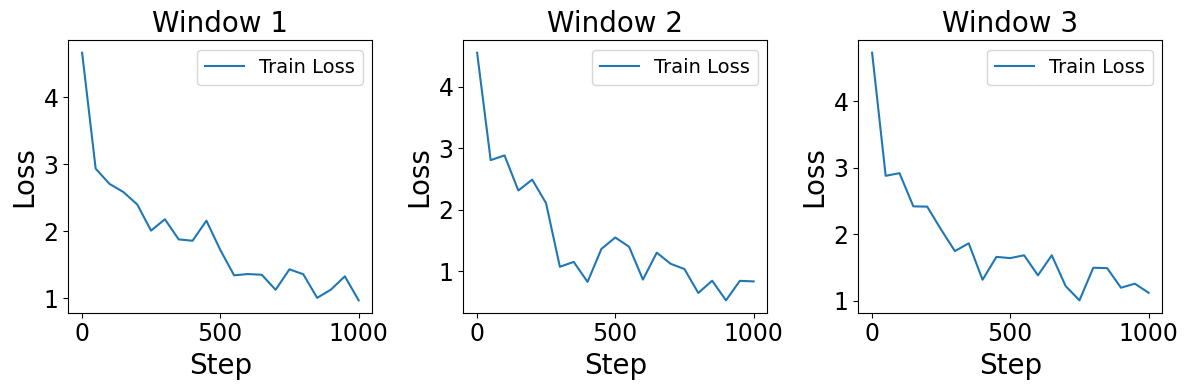

In [18]:
# Plot training history
fig, axes = plt.subplots(1, len(histories), figsize=(12, 4))
if len(histories) == 1:
    axes = [axes]

for i, history in enumerate(histories):
    axes[i].plot(history['steps'], history['train_loss'], label='Train Loss')
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Window {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

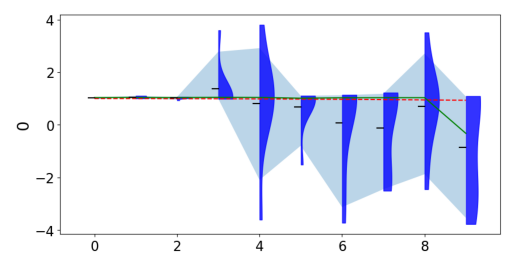

In [19]:
# Try to display trajectory image if it exists
import os

image = "./out/trajectories/trajectory_good_0_0.png"
if os.path.exists(image):
    img = plt.imread(image)
    plt.imshow(img)
    _ = plt.axis('off')
else:
    print(f"Image not found: {image}")
    print("Run evaluation with more samples to generate trajectory plots.")